## Boundless DAS

Adapted from Zhengxuan Wu's tutorial in `pyvene`.

### Overview

This tutorial aims to reproduce one key result of [the Representational Divergence paper](https://arxiv.org/abs/2511.04638). It uses the same pricing tag dataset as in the [the Boundless DAS paper](https://arxiv.org/pdf/2305.08809). Additionally, it focuses on finding alignment for the left boundary check only.

### Set-up

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# This library is our indicator that the required installs
# need to be done.
import pyvene

In [4]:
import torch
from tqdm import tqdm, trange
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
from torch.nn import CrossEntropyLoss
from tutorial_price_tagging_utils import (
    factual_sampler,
    bound_alignment_sampler,
    lower_bound_alignment_example_sampler,
)

from pyvene import (
    IntervenableModel,
    BoundlessRotatedSpaceIntervention,
    RepresentationConfig,
    IntervenableConfig,
)
from pyvene import create_llama
from pyvene import set_seed, count_parameters

from divergence_utils import get_cor_mtx, get_mse_mtx, optimal_pairs, sample_without_replacement

In [5]:
torch.cuda.device_count()

1

In [6]:
torch.set_default_device("cpu")
torch.cuda.set_device(torch.cuda.device_count()-1)

In [6]:
config, tokenizer, llama = create_llama()
_ = llama.to("cuda")  # single gpu
_ = llama.eval()  # always no grad on the model

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/34 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message


loaded model


### Factual performance of instruct-tuned LLaMA-7B

In [7]:
raw_prealign = factual_sampler(tokenizer, 5000, game="pricing_tag")
prealign_dataset = Dataset.from_dict(
    {"input_ids": raw_prealign[0], "labels": raw_prealign[1]}
)
prealign_dataset.set_format("torch", columns=["input_ids", "labels"])
prealign_dataloader = DataLoader(prealign_dataset, batch_size=64)

In [10]:
total_count = 0
correct_count = 0
with torch.no_grad():
    for step, inputs in enumerate(tqdm(prealign_dataloader)):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to(llama.device)

        # aligning forward!
        outputs = llama(
            input_ids=inputs["input_ids"],
            labels=inputs["labels"],
        )

        actual_test_labels = inputs["labels"][:, -1]
        pred_test_labels = torch.argmax(outputs.logits[:, -1], dim=-1)

        correct_labels = actual_test_labels == pred_test_labels

        total_count += len(correct_labels)
        correct_count += correct_labels.sum().tolist()
current_acc = round(correct_count / total_count, 2)
print(f"[WARNING: THIS NEEDS TO BE GOOD!] prealign task accuracy: {current_acc}")

  3%|███▋                                                                                                                                              | 2/79 [00:02<01:47,  1.39s/it]


KeyboardInterrupt: 

### Create training dataset for our trainable intervention (Boundless DAS)

In [8]:
set_seed(42)

###################
# data loaders
###################
raw_data = bound_alignment_sampler(
    tokenizer, 10000, [lower_bound_alignment_example_sampler]
)


In [10]:
batch_size = 64
n_train = 8000
n_eval = 1000
n_test = 1000

raw_train = (
    raw_data[0][:n_train],
    raw_data[1][:n_train],
    raw_data[2][:n_train],
    raw_data[3][:n_train],
    raw_data[4][:n_train],
)
raw_eval = (
    raw_data[0][n_train:n_train+n_eval],
    raw_data[1][n_train:n_train+n_eval],
    raw_data[2][n_train:n_train+n_eval],
    raw_data[3][n_train:n_train+n_eval],
    raw_data[4][n_train:n_train+n_eval],
)
raw_test = (
    raw_data[0][-n_test:],
    raw_data[1][-n_test:],
    raw_data[2][-n_test:],
    raw_data[3][-n_test:],
    raw_data[4][-n_test:],
)
train_dataset = Dataset.from_dict(
    {
        "input_ids": raw_train[0],
        "source_input_ids": raw_train[1],
        "labels": raw_train[2],
        "intervention_ids": raw_train[3],  # we will not use this field
        "cl_input_ids": raw_train[4],
        "indices": [i for i in range(len(raw_train[0]))],
    }
).with_format("torch")
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
)
eval_dataset = Dataset.from_dict(
    {
        "input_ids": raw_eval[0],
        "source_input_ids": raw_eval[1],
        "labels": raw_eval[2],
        "intervention_ids": raw_eval[3],  # we will not use this field
        "cl_input_ids": raw_eval[4],
        "indices": [i for i in range(len(raw_eval[0]))],
    }
).with_format("torch")
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    shuffle=False,
)
test_dataset = Dataset.from_dict(
    {
        "input_ids": raw_test[0],
        "source_input_ids": raw_test[1],
        "labels": raw_test[2],
        "intervention_ids": raw_test[3],  # we will not use this field
        "cl_input_ids": raw_test[4],
        "indices": [i for i in range(len(raw_test[0]))],
    }
).with_format("torch")
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

### Boundless DAS on Position-aligned Tokens

In [11]:
def simple_boundless_das_position_config(model_type, intervention_type, layer):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                layer,              # layer
                intervention_type,  # intervention type
            ),
        ],
        intervention_types=BoundlessRotatedSpaceIntervention,
    )
    return config


layer_num = 15
config = simple_boundless_das_position_config(
    type(llama), "block_output", layer_num
)
intervenable = IntervenableModel(config, llama)
intervenable.set_device("cuda")
intervenable.disable_model_gradients()

# Will use the comms_dict to collect the source and intervened vectors from
# the Boundless DAS intervention module.
# After each intervention, these vectors will be stored in the keys "source_vectors"
# and "intrv_vectors" dict keys respectively.
key = list(intervenable.interventions.keys())[0]
das_object = intervenable.interventions[key][0]
comms_dict = das_object.comms_dict

In [12]:
def collect_source_vectors(intervenable, dataloader, source_key="cl_input_ids"):
    source_vectors = []
    tqdm_iterator = tqdm(dataloader, desc="Collecting CL Vectors")
    with torch.no_grad():
        for inputs in tqdm_iterator:
            for k, v in inputs.items():
                if v is not None and isinstance(v, torch.Tensor):
                    inputs[k] = v.to("cuda")
            _, _ = intervenable(
                {"input_ids": inputs["input_ids"]},
                [{"input_ids": inputs[source_key]}],
                {"sources->base": 80},  # swap 80th token
            )
            source_vectors.append(comms_dict["source"])
    return torch.vstack(source_vectors)

# We can collect the CL vectors by running the CL data as the source data and
# collecting the source vectors from the Boundless DAS intervention module.
print("Collecting train set cl vectors")
train_cl_vectors = collect_source_vectors(intervenable, train_dataloader).cpu()
print("Collecting eval set cl vectors")
eval_cl_vectors = collect_source_vectors(intervenable, eval_dataloader).cpu()
print("Collecting test set cl vectors")
test_cl_vectors = collect_source_vectors(intervenable, test_dataloader).cpu()

In [14]:
combination_type = "full_match"
cl_keys = ["full_match"]
train_cl_vector_dict ={cl_keys[0]: train_cl_vectors}
eval_cl_vector_dict = {cl_keys[0]: eval_cl_vectors}
test_cl_vector_dict = {cl_keys[0]: test_cl_vectors}

train_cl_failure_dict ={cl_keys[0]: torch.zeros(n_train).bool()}
eval_cl_failure_dict = {cl_keys[0]: torch.zeros(n_eval).bool()}
test_cl_failure_dict = {cl_keys[0]: torch.zeros(n_test).bool()}

In [15]:
# You can define your custom compute_metrics function.
def compute_metrics(eval_preds, eval_labels):
    total_count = 0
    correct_count = 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        actual_test_labels = eval_label[:, -1]
        pred_test_labels = torch.argmax(eval_pred[:, -1], dim=-1)
        correct_labels = actual_test_labels == pred_test_labels
        total_count += len(correct_labels)
        correct_count += correct_labels.sum().tolist()
    accuracy = round(correct_count / total_count, 2)
    return {"accuracy": accuracy}

def calculate_loss(logits, labels):
    shift_logits = logits[..., :, :].contiguous()
    shift_labels = labels[..., :].contiguous()
    # Flatten the tokens
    loss_fct = CrossEntropyLoss()
    shift_logits = shift_logits.view(-1, intervenable.model_config.vocab_size)
    shift_labels = shift_labels.view(-1)
    # Enable model parallelism
    shift_labels = shift_labels.to(shift_logits.device)
    loss = loss_fct(shift_logits, shift_labels)

    for k, v in intervenable.interventions.items():
        boundary_loss = 1.0 * v[0].intervention_boundaries.sum()
    loss += boundary_loss

    return loss



In [16]:
def cl_loss_fn(intrv_vectors, cl_vectors, loss_type="both"):
    """
    Calculate the loss between the intervention vectors and the cl vectors.
    """
    mse,cos = 0.0,0.0
    if loss_type in {"both","mse"}:
        mse = (intrv_vectors-cl_vectors).pow(2).mean()
    if loss_type in {"both","cos"}:
        cos = 1-torch.cosine_similarity(intrv_vectors,cl_vectors,dim=-1).mean()
    return mse+cos

def rotated_cl_loss(das_object, intrv_vectors, cl_vectors, mask_idx=0, loss_type="both"):
    """
    Calculate the loss between the intervention vectors and the cl vectors.
    """
    mask = das_object.get_boundary_mask(
        intrv_vectors.shape[0], intrv_vectors.device, intrv_vectors.dtype
    )
    mask = mask-mask_idx
    intrv_vectors = das_object.rotate_layer(intrv_vectors)*mask
    with torch.no_grad():
        c_vectors = das_object.rotate_layer(cl_vectors)*mask
    return cl_loss_fn(intrv_vectors, c_vectors.data, loss_type)

def calculate_cl_loss(
        intrv_vectors,
        inputs,
        cl_vector_dict,
        cl_failure_dict,
        das_object,
        do_rotate=True
):
    device = next(das_object.parameters()).data.device
    intrv_vectors = intrv_vectors.to(device)
    cl_loss = 0.0
    cl_idxs = inputs["indices"].long().to(device)
    for cl_key in cl_vector_dict.keys():
        cl_vectors = cl_vector_dict[cl_key].to(device)[cl_idxs]
        cl_keeps = ~cl_failure_dict[cl_key].to(device)[cl_idxs]
        if do_rotate:
            cl_l = rotated_cl_loss(
                das_object, intrv_vectors[cl_keeps], cl_vectors[cl_keeps], loss_type="both")
        else:
            cl_l = cl_loss_fn(intrv_vectors[cl_keeps], cl_vectors[cl_keeps], loss_type="both")
        cl_loss += cl_l
        cl_vector_dict[cl_key] = cl_vector_dict[cl_key].cpu()
        cl_failure_dict[cl_key] = cl_failure_dict[cl_key].cpu()
    return cl_loss / len(cl_vector_dict.keys())

In [18]:
epochs = 3

train_dataloader = DataLoader(
    train_dataloader.dataset,
    batch_size=32,
    shuffle=True,
)
t_total = int(len(train_dataloader) * 3)
warm_up_steps = 0.1 * t_total
optimizer_params = []
for k, v in intervenable.interventions.items():
    optimizer_params += [{"params": v[0].rotate_layer.parameters()}]
    optimizer_params += [{"params": v[0].intervention_boundaries, "lr": 1e-2}]
optimizer = torch.optim.Adam(optimizer_params, lr=1e-3)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warm_up_steps, num_training_steps=t_total
)

gradient_accumulation_steps = 4
target_total_step = len(train_dataloader) * epochs
temperature_start = 50.0
temperature_end = 0.1
temperature_schedule = (
    torch.linspace(temperature_start, temperature_end, target_total_step)
    .to(torch.bfloat16)
    .to("cuda")
)
intervenable.set_temperature(temperature_schedule[0])

In [ ]:
cl_eps = 5

intervenable.model.train()  # train enables drop-off but no grads
print("llama trainable parameters: ", count_parameters(intervenable.model))
print("intervention trainable parameters: ", intervenable.count_parameters())
train_iterator = trange(0, int(epochs), desc="Epoch")
total_step = 0
for epoch in train_iterator:
    epoch_iterator = tqdm(
        train_dataloader, desc=f"Epoch: {epoch}", position=0, leave=True
    )
    train_intrv_hstates = []
    train_cl_hstates = []
    for step, inputs in enumerate(epoch_iterator):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to("cuda")
        b_s = inputs["input_ids"].shape[0]
        _, counterfactual_outputs = intervenable(
            {"input_ids": inputs["input_ids"]},
            [{"input_ids": inputs["source_input_ids"]}],
            {"sources->base": 80},  # swap 80th token
        )
        eval_metrics = compute_metrics(
            [counterfactual_outputs.logits], [inputs["labels"]]
        )

        # loss and backprop
        loss = calculate_loss(counterfactual_outputs.logits, inputs["labels"])
        actn_loss = loss

        # CL Loss
        cl_loss = calculate_cl_loss(
            intrv_vectors=comms_dict["intrv_vectors"],
            inputs=inputs,
            cl_vector_dict=train_cl_vector_dict,
            cl_failure_dict=train_cl_failure_dict,
            das_object=das_object,
            do_rotate=True,
        )
        loss = loss + cl_eps*cl_loss
        
        # Print Loss
        loss_str = round(actn_loss.item(), 2)
        cl_loss_str = round(cl_loss.item(), 4)
        epoch_iterator.set_postfix({"loss": loss_str, "acc": eval_metrics["accuracy"], "CL": cl_loss_str})

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()
        if total_step % gradient_accumulation_steps == 0:
            if not (gradient_accumulation_steps > 1 and total_step == 0):
                optimizer.step()
                scheduler.step()
                intervenable.set_zero_grad()
                intervenable.set_temperature(
                    temperature_schedule[min(total_step,len(temperature_schedule))]
                )
        total_step += 1
        
        train_intrv_hstates.append(comms_dict["intrv_vectors"].cpu())
        train_cl_hstates.append(train_cl_vector_dict[cl_keys[0]][inputs["indices"].cpu().long()].cpu())
    torch.cuda.empty_cache()
train_eval_metrics = eval_metrics

llama trainable parameters:  0
intervention trainable parameters:  16777218


Epoch: 3:  32%|████████████████████████████████▏                                                                     | 79/250 [05:20<11:30,  4.04s/it, loss=0.48, acc=0.97, CL=0.0194]

In [25]:
comms_dict["source"].shape

torch.Size([40, 4096])

In [26]:
train_eval_metrics = eval_metrics

In [27]:
torch.cuda.empty_cache()

In [28]:
intervenable.model.eval()
device = "cuda"
intervenable.model.to(device)  # train enables drop-off but no grads
intervenable.to(device)  # train enables drop-off but no grads
das_object.to(device)
# evaluation on the test set
eval_labels = []
eval_preds = []
cl_hstates = []
intrv_hstates = []
with torch.no_grad():
    epoch_iterator = tqdm(test_dataloader, desc=f"Test")
    for step, inputs in enumerate(epoch_iterator):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to(device)
        b_s = inputs["input_ids"].shape[0]
        base_outputs, counterfactual_outputs = intervenable(
            {"input_ids": inputs["input_ids"]},
            [{"input_ids": inputs["source_input_ids"]}],
            {"sources->base": 80},  # swap 80th token
            output_original_output=True,
            output_hidden_states=False,
        )
        eval_labels += [inputs["labels"]]
        eval_preds += [counterfactual_outputs.logits]
        intrv_hstates.append(comms_dict["intrv_vectors"].cpu())
        cl_hstates.append(test_cl_vector_dict[cl_keys[0]].cpu()[inputs["indices"].long().cpu()].cpu())
        # base_hstates.append([h.cpu() for h in base_outputs.hidden_states])
        # intrv_hstates.append([h.cpu() for h in counterfactual_outputs.hidden_states])
eval_metrics = compute_metrics(eval_preds, eval_labels)
print(eval_metrics)

Test: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.79s/it]

{'accuracy': 0.92}


In [30]:
intrv_train_states = torch.vstack(train_intrv_hstates)
natty_train_states = torch.vstack(train_cl_hstates)

In [29]:
intrv_states = torch.vstack(intrv_hstates)
natty_states = torch.vstack(cl_hstates)

In [48]:
os.makedirs("./cl_boundless_actvs", exists_ok=True)
torch.save(
    {"intrv": intrv_states, "natty": natty_states},
    "./cl_boundless_actvs/cl_boundless_actvs.p"
)

In [26]:
dir_path = "./cl_boundless_actvs/"
[pt for pt in os.listdir(dir_path) if "0.0" in pt]

['cl_eps_10.0_seed_12347_dorotFalse_20251118_180253.pt',
 'cl_eps_10.0_seed_12345_dorotFalse_20251118_180253.pt',
 'cl_eps_10.0_seed_12346_dorotFalse_20251118_180253.pt',
 'cl_eps_10.0_seed_12345_dorotFalse_20251118_011037.pt',
 'cl_eps_0.0_seed_37077_dorotFalse_20251119_211810.pt',
 'cl_eps_50.0_seed_12345_20251117_201206.pt',
 'cl_eps_50.0_seed_12345_dorotFalse_20251118_011037.pt',
 'cl_eps_10.0_seed_12345_20251117_201206.pt',
 'cl_eps_0.0_seed_12345_20251117_201206.pt',
 'cl_eps_0.0_seed_12387_dorotFalse_20251119_211810.pt',
 'cl_eps_100.0_seed_12345_dorotFalse_20251118_095858.pt',
 'cl_eps_0.0_seed_24732_dorotFalse_20251119_211810.pt']

In [28]:
fname = "cl_eps_0.0_seed_12387_dorotFalse_20251119_211810.pt"
cl_eps = float(fname.split("cl_eps_")[-1].split("_")[0])
d = torch.load(os.path.join(dir_path, fname))
intrv_states = d["intrv_states"]
natty_states = d["natty_states"]


Natty: torch.Size([1000, 4096])
Intrv: torch.Size([1000, 4096])


/home/grantsrb/anaconda3/lib/python3.11/site-packages/torch/utils/_device.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:183: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:192: UserWarning: No artists with labels found to put in legend.  Not

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.2231, 0.1220, 0.0883, 0.0546, 0.0440])
Vis Expl Vars: tensor(0.2231) tensor(0.1220)


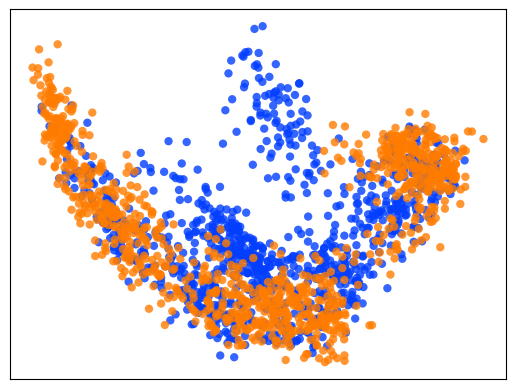

Computing EMD
Computing Cosine Cost
Computing Nearest Neighbor Cost Cosine
Computing MSE Cost
Computing Nearest Neighbor Cost MSE
Computing Local PCA Cost


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:36<00:00,  3.18it/s]


Computing Local Reconstruction Cost


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:33<00:00, 15.05it/s]


Computing KDE Cost


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 322.77it/s]


Computing EMD
Computing Cosine Cost
Computing Nearest Neighbor Cost Cosine
Computing MSE Cost
Computing Nearest Neighbor Cost MSE
Computing Local PCA Cost


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:06<00:00,  1.36it/s]


Computing Local Reconstruction Cost


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:48<00:00, 10.23it/s]


Computing KDE Cost


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 318.34it/s]


Computing EMD
Computing Cosine Cost
Computing Nearest Neighbor Cost Cosine
Computing MSE Cost
Computing Nearest Neighbor Cost MSE
Computing Local PCA Cost


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:49<00:00,  1.43it/s]


Computing Local Reconstruction Cost


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.23it/s]


Computing KDE Cost


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 325.23it/s]


Computing EMD
Computing Cosine Cost
Computing Nearest Neighbor Cost Cosine
Computing MSE Cost
Computing Nearest Neighbor Cost MSE
Computing Local PCA Cost


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:14<00:00,  1.33it/s]


Computing Local Reconstruction Cost


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:51<00:00,  9.69it/s]


Computing KDE Cost


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 303.57it/s]


Computing EMD
Computing Cosine Cost
Computing Nearest Neighbor Cost Cosine
Computing MSE Cost
Computing Nearest Neighbor Cost MSE
Computing Local PCA Cost


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:54<00:00,  1.70it/s]


In [ ]:
import os
import pandas as pd
import numpy as np
from divergence_utils import visualize_states, collect_divergences
np.random.seed(12345)
torch.manual_seed(12345)

n_samples = 5
sample_size = 5000
d = natty_states.shape[-1]
natty_states = natty_states.float()
intrv_states = intrv_states.float()

print()
print("Natty:", natty_states.shape)
print("Intrv:", intrv_states.shape)
emd_df_dict = {
    "sample_id": [],
}
for samp_id in range(n_samples):
    with torch.no_grad():
        if samp_id==0:
            visualize_states(
                natty_states.cpu().detach(),
                intrv_states.cpu().detach(),
                xdim=0,
                ydim=1,
                save_name="figs/das_divergence.png",
                expl_var_threshold=0,
                visualize=samp_id==0,
                pca_batch_size=500,
            )
        diffs = collect_divergences(
            natty_vecs=natty_states,
            intrv_vecs=intrv_states,
            sample_size=sample_size,
            compute_all_divergences=True,
        )
    emd_df_dict["sample_id"].append(samp_id)
    for k,v in diffs.items():
        if k not in emd_df_dict:
            emd_df_dict[k] = []
        emd_df_dict[k].append(float(v))
    
emd_df = pd.DataFrame(emd_df_dict)
    

In [32]:
emd_df

,sample_id,mse,emd,cost_cos,nn_cos,cost_mse,nn_mse,local_pca,lle_recon,kde,base_emd,base_cost_cos,base_nn_cos,base_cost_mse,base_nn_mse,base_local_pca,base_lle_recon,base_kde
0,0,0.021008,31.565128,0.021462,0.019297,0.017708,0.015963,6.377237,6.316375,139.717127,6.942384,0.004786,0.002847,0.003940,0.002330,1.910702,1.405914,38.647705
1,1,0.021008,31.906542,0.021841,0.019571,0.018032,0.016186,6.444869,6.386272,138.491651,7.232845,0.005233,0.003084,0.004313,0.002525,1.965252,1.496549,40.690779
2,2,0.021008,31.266512,0.021552,0.019537,0.017789,0.016149,6.397414,6.341839,137.767704,7.044073,0.004739,0.002844,0.003896,0.002328,1.919667,1.423492,40.442079
3,3,0.021008,31.670439,0.022020,0.019868,0.018164,0.016417,6.488611,6.430086,141.249292,7.394894,0.004810,0.003145,0.003956,0.002589,1.991718,1.513493,40.534886
4,4,0.021008,31.672640,0.022253,0.019926,0.018340,0.016480,6.492963,6.432840,135.876370,6.968050,0.004675,0.002944,0.003847,0.002419,1.961196,1.471145,39.097796


In [33]:
emd_df["method"] = "das"
if not os.path.exists("csvs/"):
    os.mkdir("csvs/")
emd_df.to_csv(f"csvs/das_emd_cleps{cl_eps}.csv", header=True, index=False)

In [34]:
cl_eps

0.0